# Training

## Imports

In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns

from src.Network import RegressionNet
from src import Dataset, DecisionMaker
os.chdir(os.path.dirname(os.getcwd()))

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [2]:

# Hyperparameter
hparams = {
    "days_of_data": 64,
    "batch_size": 256,
    "lr": 0.01,
    "n_hidden": 1600,
    "layers": 1,
    "optim": "Adam",
    "weight_decay": 0.0,
    "loss": "L1",
    "label": "Open",
    "label_type": "real",
    "threshold": 0.0,
    "normalization": "min_max",
}

In [3]:
# Model initialization
model = RegressionNet.RegressionNet(hparams=hparams)
# wandb.watch(model)

Cuda available: True
Device: cuda:0
loss is L1


## Trainer

In [4]:
# more Hyperparameter
gpus=1
max_epochs=125
# min_epochs =
fast_dev_run = True
overfit_pct = 0.25

In [5]:
# os.chdir(os.path.dirname(os.getcwd()))
# Trainer initialization
trainer = pl.Trainer(
    gpus=gpus,
    max_epochs=max_epochs,
    default_save_path=os.getcwd() + "/DeepStock",
#     fast_dev_run = fast_dev_run,
#     min_epochs=min_epochs,
#     auto_scale_batch_size='binsearch',
#     auto_lr_find=auto_lr_find,
#     checkpoint_callback=checkpoint_callback,
#     overfit_pct=overfit_pct,

)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [6]:
# train model
trainer.fit(model)

computing computed_Open_real_0.0_min_max_ADBE.csv ...
computing finished.
computing computed_Open_real_0.0_min_max_AMD.csv ...
computing finished.
computing computed_Open_real_0.0_min_max_FB.csv ...
computing finished.
computing computed_Open_real_0.0_min_max_GOOG.csv ...
computing finished.
computing computed_Open_real_0.0_min_max_INTC.csv ...
computing finished.
computing computed_Open_real_0.0_min_max_NVDA.csv ...
computing finished.
computing computed_Open_real_0.0_min_max_PYPL.csv ...
computing finished.
loading computed_Open_real_0.0_min_max_AAPL.csv
Dataset length: 40032
train_size: 32026
val_size: 8006
test_size: 9885



  | Name   | Type        | Params
-----------------------------------
0 | lstm   | Sequential  | 10 M  
1 | lstm.0 | LSTM        | 10 M  
2 | fc1    | Sequential  | 2 M   
3 | fc1.0  | Linear      | 2 M   
4 | fc1.1  | BatchNorm1d | 3 K   
5 | fc1.2  | PReLU       | 1     
6 | fc1.3  | Linear      | 1 K   


optim is Adam


Epoch    23: reducing learning rate of group 0 to 1.0000e-03.


Epoch    41: reducing learning rate of group 0 to 1.0000e-04.


Detected KeyboardInterrupt, attempting graceful shutdown...


1

In [7]:
path = os.getcwd() + "/Code/Saved Models/model.pth"

# torch.save(model, path)

# model = torch.load(path)
model.eval()
trainer.test()

--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.0793, device='cuda:0')}
--------------------------------------------------------------------------------



## Evaluate

LSTM(6, 1600)
weight_ih_l0


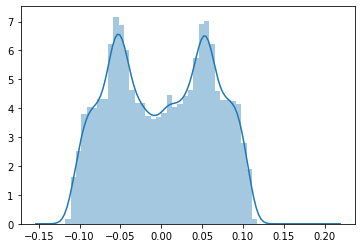

weight_hh_l0


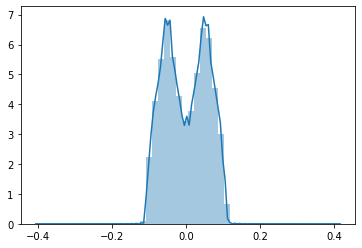

bias_ih_l0


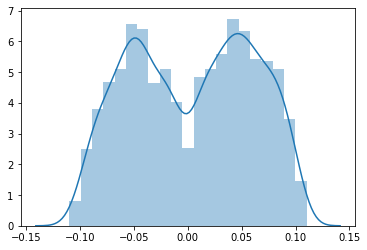

bias_hh_l0


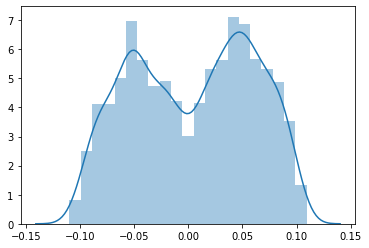

Linear(in_features=1600, out_features=1600, bias=True)


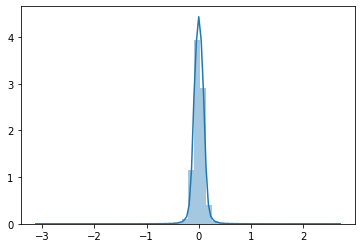

Linear(in_features=1600, out_features=1, bias=True)


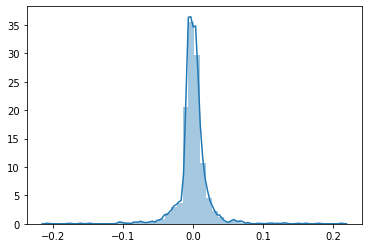

In [8]:
for m in model.modules():
    if isinstance(m, nn.Linear):
        print(m)
        sns.distplot(m.weight.data.cpu())
        plt.show()
    if isinstance(m, nn.Conv2d):
        print(m)
        sns.distplot(m.weight.data.cpu())
        plt.show()
    if isinstance(m, nn.LSTM):
        print(m)
        for name, param in m.named_parameters():
            if 'bias' in name:
                print(name)
                sns.distplot(param.data.cpu())
                plt.show()
            if 'weight' in name:
                print(name)
                sns.distplot(param.data.cpu())
                plt.show()

In [9]:
root = os.getcwd()
print(os.getcwd())

dataset = Dataset.StockDataset(
    csv_path=root + "/DeepStock/Data/test/AAPL.csv", 
    days_of_data=model.hparams["days_of_data"], 
    label=model.hparams["label"],
    label_type=model.hparams["label_type"],
    threshold=model.hparams["threshold"],
    normalization=model.hparams["normalization"],
    training=False,
)
# print(dataset.__getitem__(0))

/media/thilo/D68C8E958C8E7033/Users/threi/OneDrive/Thilo Reintjes/Projekte
computing computed_Open_real_0.0_min_max_AAPL.csv ...
computing finished.


In [10]:
y_hat_list = []
y_list = []
y_hat_norm_list = []
y_norm_list = []
acc_list = []
n = dataset.__len__()
print(n)
for i in range(n):
    with torch.no_grad():
        data, label, date = dataset.__getitem__(dataset.__len__() - n + i)
        
#         data = torch.reshape(data, (1, -1))
        data = data.unsqueeze(0)
        label =  label.to(device)
        data = data.to(device)
        label = label.to(device)
        
        model.eval()
        model.to(device)
#         print(model.forward(data))
        y_hat = model.forward(data).item()
        y_hat_list.append(y_hat)
#         y_hat = ((y_hat + 1) / 2) * (date[2][1].item() - date[2][0].item()) + date[2][0].item()
#         y_hat_norm_list.append(y_hat)
        y = label.item()
        y_list.append(y)
#         y = date[4].item()
#         y_norm_list.append(y)
        acc = y - y_hat
        acc_list.append(acc)

9885


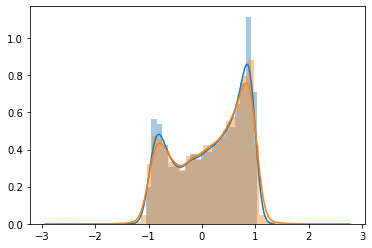

Min y: -2.616351366043091 Min y_hat: -1.1604440212249756
Max y: 2.4482736587524414 Max y_hat: 1.0286837816238403
Avg y: 0.16053517932655478 Avg y_hat: 0.15607605899147572
Min acc: -2.31882244348526
Max acc: 1.5127508640289307
Avg acc: 0.004459120335079047
Std dev y: 0.6383435455025195 Std dev acc: 0.12322288566637571
------------------------


In [11]:
sns.distplot(y_hat_list)
sns.distplot(y_list)
plt.show()


print("Min y:", min(y_list), "Min y_hat:", min(y_hat_list))
print("Max y:", max(y_list), "Max y_hat:", max(y_hat_list))
print("Avg y:", sum(y_list) / len(y_list), "Avg y_hat:", sum(y_hat_list) / len(y_hat_list))
print("Min acc:", min(acc_list))
print("Max acc:", max(acc_list))Close
print("Avg acc:", sum(acc_list) / len(acc_list))
print("Std dev y:", statistics.stdev(y_list), "Std dev acc:", statistics.stdev(acc_list))
print("------------------------")
# print("Min y:", min(y_norm_list), "Min y_hat:", min(y_hat_norm_list))
# print("Max y:", max(y_norm_list), "Max y_hat:", max(y_hat_norm_list))
# print("Avg y:", sum(y_norm_list) / len(y_norm_list), "Avg y_hat:", sum(y_hat_norm_list) / len(y_hat_norm_list))


In [12]:
if model.hparams["label_type"]  is "real":
    n = 100
    trader = DecisionMaker
    pred_norm, pred = trader.last_n_days(model, dataset, n, model.hparams["label_type"])
    
    label_norm = [d['label'] for d in pred_norm]
    y_hat_norm = [d['predicted'] for d in pred_norm]
    
    label = [d['label'] for d in pred]
    y_hat = [d['predicted'] for d in pred]
#     print(min(label_norm))
    
    #plt
    y = list(range(n))
    plt.plot(y, label, y, y_hat)
    plt.show()
    plt.plot(y, label_norm, y, y_hat_norm)
    plt.show()


ValueError: too many values to unpack (expected 2)

0 long trades,  0 short trades 0 total trades / 500 

Sum:
Long: 0 Short: 0 

Avg Profit:




ValueError: x and y must have same first dimension, but have shapes (500,) and (1,)

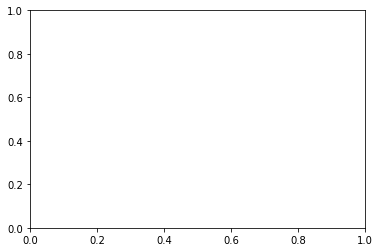

In [14]:
n = 500
trader = DecisionMaker
pred, long, short = trader.last_n_days(model, dataset, n, model.hparams["label_type"], threshold=0.01)
label = [d['label'] for d in pred]
y_hat = [d['predicted'] for d in pred]
long_gain = [x["diff"] for x in long]
short_gain =[x["diff"] for x in short]

print(len(long),"long trades, ", len(short), "short trades", len(long) + len(short), "total trades /",n , "\n")

print("Sum:")
print("Long:", sum(long_gain), "Short:", sum(short_gain), "\n")

print("Avg Profit:")
if len(long) > 0:
    print("Long:", sum(long_gain) / len(long), end=' ')
if len(short) > 0:
    print("Short:", sum(short_gain) / len(short))
print("\n")

if len(long) > 0:
    long_idx = np.argmax(long_gain)
    print("Best long day:\n", long[long_idx])
    long_idx = np.argmin(long_gain)
    print("Worst long day:\n", long[long_idx], "\n")
if len(short) > 0:
    short_idx = np.argmin(short_gain)
    print("Best short day:\n", short[short_idx])
    short_idx = np.argmax(short_gain)
    print("Worst short day:\n", short[short_idx])

# plt
# print(pred["predicted"])
y = list(range(n))
plt.plot(y, label, y, y_hat)
plt.show()

In [ ]:
test = [1,2,3,4,5,6]

a = torch.as_tensor([test, test])
print(a.shape)